In [146]:
# ! pip install ipympl
#! pip install scikit-learn
#! pip install seaborn

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns


# 1. 데이터 로딩 및 전처리

In [43]:
# 예시 경로, 실제 경로로 수정 필요

# 게임에 참가한 사람들의 고유 정보
participants = pd.read_csv("data/user/participants.csv")
# 시간 흐름에 따라 변화하는 실시간 스탯 (골드, 딜량 등) 
participants_frames = pd.read_csv("data/user/participant_frames.csv")
# 게임 단위의 결과 (승패 등)
matches = pd.read_csv("data/user/matches.csv")
# 킬 이벤트 정보 (누가 누구를 죽였는지)
champ_kill = pd.read_csv('data/user/events__CHAMPION_KILL.csv')

In [44]:
# 가장 마지막 프레임만 사용 (게임 종료 시점 상태)
# 게임 종료 시점 기준으로 정보 하나로 묶기
latest_frames = participants_frames.sort_values("frame_timestamp").drop_duplicates(
    subset=["game_id", "participant_id"], keep='last'
)

merged_df = pd.merge(participants, latest_frames, on=["game_id", "participant_id"], how="left")

## 2. KDA 및 주요 파생 지표 생성

### KDA 계산

컬럼 | 의미
---- | ----
kills | 해당 경기에서 몇 번 킬 했는가
deaths | 몇 번 죽었는가
assists | 어시스트 수
KDA | (킬 + 어시스트) / 데스 (생존 기반 전투 영향력)

In [45]:
# kills 수 계산 (킬한 사람 기준)
kills = champ_kill.groupby(["game_id", "killer_id"]).size().reset_index(name="kills")
kills.rename(columns={"killer_id": "participant_id"}, inplace=True)

In [46]:
# deaths 수 계산 (죽은 사람 기준)
deaths = champ_kill.groupby(["game_id", "victim_id"]).size().reset_index(name="deaths")
deaths.rename(columns={"victim_id": "participant_id"}, inplace=True)

In [47]:
# assists 수 계산
assist_df = pd.read_csv("data/top1000/event_assists.csv")

# 게임 ID + 어시스트 참가자 ID로 그룹화
assists = assist_df.groupby(["game_id", "participant_id"]).size().reset_index(name="assists")


In [48]:
# KDA 구하기

# 기본 participant list (merged_df)에서 가져오자
kda_base = merged_df[["game_id", "participant_id", "puuid"]].drop_duplicates()

# 병합
kda_df = (
    kda_base
    .merge(kills, on=["game_id", "participant_id"], how="left")
    .merge(deaths, on=["game_id", "participant_id"], how="left")
)

# 어시스트 컬럼 있으면 병합
if 'assists' in locals():
    kda_df = kda_df.merge(assists, on=["game_id", "participant_id"], how="left")

# 결측값 0으로 채우기
kda_df[["kills", "deaths", "assists"]] = kda_df[["kills", "deaths", "assists"]].fillna(0).astype(int)

# KDA 계산
# 분모가 0이 되면 오류가 나기 때문에, 완벽 생존은 1로 나눈 값을 최대치로 보정
kda_df["KDA"] = (kda_df["kills"] + kda_df["assists"]) / kda_df["deaths"].replace(0, 1)


In [49]:
# merged_df에 병합

merged_df = pd.merge(merged_df, kda_df[["game_id", "participant_id", "kills", "deaths", "assists", "KDA"]],
                     on=["game_id", "participant_id"], how="left")
merged_df.head()

,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,totalDamageDone,totalDamageDoneToChampions,totalDamageTaken,trueDamageDone,trueDamageDoneToChampions,trueDamageTaken,kills,deaths,assists,KDA
0,7494844141,1,FjQNTm2bigLzOTT-Z3OHxkOUv03NA94H5MtpbZvZ5rReDq...,2109058,41,0,192,16,27,808201,...,282328,30644,53658,80762,2110,965,7,11,0,0.636364
1,7494844141,2,GIMAB6FWhOn1fGc3QwGL1N9-4Zp9bLF7OQFZUMveLZRAN7...,2109058,54,0,4,16,184,66402,...,118735,23226,30316,13692,2111,746,3,8,0,0.375000
2,7494844141,3,GUtnltQQ4cxM_6Pf1Kl5OqzPzs-NFR8-0xcb3g_oi2uVP8...,2109058,697,0,0,16,191,292153,...,109884,11419,38977,878,0,911,0,10,0,0.000000
3,7494844141,4,IRp95UwU1QKgaiSJCTjO3aYlIiVMopikQs7_bBglbHxZNu...,2109058,1466,0,32,18,341,28975,...,402103,68445,25425,9706,504,1067,11,7,0,1.571429
4,7494844141,5,-d5MIcv7Gtetq5g1xLaolc5qUozE9oX3ogQQJCLK2RCUv_...,2109058,197,50,0,14,18,137149,...,18499,7148,24831,4038,0,562,0,10,0,0.000000


## 유사도 기반 파생 지표 생성 (예시: 시야 점수, 미니언 수, 골드 등)

### 성장 및 경제 지표        

| 지표 | 의미 | 해석 |  
| ---- | ---- | ---- |   
| CS/Min | 분당 미니언 수급량 | 파밍 능력 |     
| Gold/Min | 분당 골드 | 성장 속도 |        
| XP/Min | 분당 경험치 | 레벨 성장 속도 |       




In [50]:
# 성장 및 경제 지표

# 분당 라인 몬스터 
merged_df['lane_cs_per_min'] = merged_df['minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# 분당 정글 몬스터
merged_df['jungle_cs_per_min'] = merged_df['jungle_minions_killed'] / (merged_df["frame_timestamp"] / 60000)

# # CS (미니언 + 정글)
# merged_df["cs"] = merged_df["minions_killed"] + merged_df["jungle_minions_killed"]

# # 분당 CS
# merged_df["cs_per_min"] = merged_df["cs"] / (merged_df["frame_timestamp"] / 60000)

# jungle 성향 분석
merged_df['jungle_ratio'] = merged_df['jungle_minions_killed'] / (merged_df['jungle_minions_killed'] + merged_df['minions_killed'])

# 분당 골드
merged_df["gold_per_min"] = merged_df["total_gold"] / (merged_df["frame_timestamp"] / 60000)

# 분당 경험치
merged_df["xp_per_min"] = merged_df["xp"] / (merged_df["frame_timestamp"] / 60000)

### 전투 능력 지표

지표 | 의미 | 해석
---- | ---- | ----
Damage/Min | 분당 딜량 | 전투 기여도
Damage Taken/Min | 분당 받은 피해 | 탱킹 능력 또는 위험 노출
KA/Min | 분당 킬 관여 수 | 싸움 참여율 (적극적인지 여부)
Damage Efficiency | 피해 교환 비율 | 딜 효율 (딜을 얼마나 잘 넣고 덜 맞았는지)

In [51]:
# 전투력 관련 지표
# 분당 피해량
merged_df["damage_per_min"] = merged_df["totalDamageDoneToChampions"] / (merged_df["frame_timestamp"] / 60000)

# 분당 받은 피해량
merged_df["damage_taken_per_min"] = merged_df["totalDamageTaken"] / (merged_df["frame_timestamp"] / 60000)

# 분당 킬 관여율 (K+A)/시간
merged_df["ka_per_min"] = (merged_df["kills"] + merged_df["assists"]) / (merged_df["frame_timestamp"] / 60000)

# 피해 교환 효율 (딜량 / 받은 피해량)
merged_df["damage_efficiency"] = merged_df["totalDamageDoneToChampions"] / merged_df["totalDamageTaken"].replace(0, 1)


### 생존력 지표

지표 | 의미 | 해석
---- | ---- | ----
survivability | 생존률 | 
healthregen_per_min | 분당 체력 재생 | 


In [52]:
# 생존력 지표
# 생존률 (1 - 데스 / 평균 생존시간) → 데스 적을수록 높음
merged_df["survivability"] = 1 / merged_df["deaths"].replace(0, 1)

# 1. healthregen의 총합을 참가자별로 groupby
agg_df = participants_frames.groupby(['game_id', 'participant_id']).agg({
    'healthregen': 'sum',
    'frame_timestamp': 'max'  # 해당 플레이어의 게임 시간 (ms)
}).reset_index()

# 2. 게임 시간(ms)를 분 단위로 변환
agg_df['game_time_min'] = agg_df['frame_timestamp'] / 60000

# 3. 분당 체력 재생량 계산
agg_df['healthregen_per_min'] = agg_df['healthregen'] / agg_df['game_time_min']

# 4. merged_df에 병합 (game_id + participant_id 기준)
merged_df = merged_df.merge(
    agg_df[['game_id', 'participant_id', 'healthregen_per_min']],
    on=['game_id', 'participant_id'],
    how='left'
)

# # 분당 체력 재생
# merged_df["healthregen_per_min"] = merged_df["healthregen"] / (merged_df["frame_timestamp"] / 60000)


### 시야 장악 지표

지표 | 의미 | 해석
---- | ---- | ----
Wards Placed/Min | 분당 설치 | 시야 제공 적극성
Wards Killed/Min | 분당 제거 | 상대 시야 차단 능력
Vision Score Est. | 설치+제거 총합 | 시야 장악 종합 평가 (approx.)

In [53]:
# 포지션 제어 / 시야 장악 지표
wards_placed = pd.read_csv("data/top1000/events__WARD_PLACED.csv")
wards_killed = pd.read_csv("data/top1000/events__WARD_KILL.csv")

## 와드 설치 수
ward_placed_count = (
    wards_placed
    .groupby(["game_id", "creator_id"])
    .size()
    .reset_index(name="wards_placed")
    .rename(columns={"creator_id": "participant_id"})
)

## 와드 제거 수
ward_kill_count = (
    wards_killed
    .groupby(["game_id", "killer_id"])
    .size()
    .reset_index(name="wards_killed")
    .rename(columns={"killer_id": "participant_id"})
)

## merged_df에 와드 수 붙이기
merged_df = (
    merged_df
    .merge(ward_placed_count, on=["game_id", "participant_id"], how="left")
    .merge(ward_kill_count, on=["game_id", "participant_id"], how="left")
)

# 결측치는 0으로 처리
merged_df[["wards_placed", "wards_killed"]] = merged_df[["wards_placed", "wards_killed"]].fillna(0).astype(int)

## 시야 제어 파생 지표 추가
# 분당 와드 설치
merged_df["wards_placed_per_min"] = merged_df["wards_placed"] / (merged_df["frame_timestamp"] / 60000)

# 분당 와드 제거
merged_df["wards_killed_per_min"] = merged_df["wards_killed"] / (merged_df["frame_timestamp"] / 60000)

# 종합 시야 지표 (설치 + 제거)
merged_df["vision_score_est"] = merged_df["wards_placed"] + merged_df["wards_killed"]


### 종합 능력치 지표
기본 아이템 + 능력치 요약

In [54]:
# 아이템/스탯 관련 종합 능력치
# 전체 공격 스탯
merged_df["offensive_score"] = merged_df["attackdamage"] + merged_df["attackspeed"]

# 전체 방어 스탯
merged_df["defensive_score"] = merged_df["armor"] + merged_df["magicresist"]

# 전체 마법 능력치
merged_df["magic_score"] = merged_df["abilitypower"] + merged_df["magicpen"] + merged_df["magicpenpercent"]


생존 또는 스킬 활용 능력

In [55]:
# 기타 유틸성 스탯
# 만능 흡혈 + 물리 흡혈 + 주문 흡혈
merged_df["total_vamp"] = merged_df[["omnivamp", "physicalvamp", "spellvamp"]].sum(axis=1)

# 스킬 쿨다운 영향력
merged_df["haste_score"] = merged_df["cooldownreduction"] + merged_df["abilityhaste"]


In [56]:
merged_df

,game_id,participant_id,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,...,wards_placed,wards_killed,wards_placed_per_min,wards_killed_per_min,vision_score_est,offensive_score,defensive_score,magic_score,total_vamp,haste_score
0,7494844141,1,FjQNTm2bigLzOTT-Z3OHxkOUv03NA94H5MtpbZvZ5rReDq...,2109058,41,0,192,16,27,808201,...,0,0,0.0,0.0,0,519,172,0,0,0
1,7494844141,2,GIMAB6FWhOn1fGc3QwGL1N9-4Zp9bLF7OQFZUMveLZRAN7...,2109058,54,0,4,16,184,66402,...,0,0,0.0,0.0,0,220,138,403,0,0
2,7494844141,3,GUtnltQQ4cxM_6Pf1Kl5OqzPzs-NFR8-0xcb3g_oi2uVP8...,2109058,697,0,0,16,191,292153,...,0,0,0.0,0.0,0,242,208,194,0,0
3,7494844141,4,IRp95UwU1QKgaiSJCTjO3aYlIiVMopikQs7_bBglbHxZNu...,2109058,1466,0,32,18,341,28975,...,0,0,0.0,0.0,0,622,157,0,0,0
4,7494844141,5,-d5MIcv7Gtetq5g1xLaolc5qUozE9oX3ogQQJCLK2RCUv_...,2109058,197,50,0,14,18,137149,...,0,0,0.0,0.0,0,213,127,147,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7276335666,6,rf8UusUjnzDhoSdnw1FjTTkHEwM4-h5Rh3xA9fe6qrb91M...,1429418,1420,0,8,15,167,328787,...,0,0,0.0,0.0,0,371,178,212,0,0
96,7276335666,7,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,1429418,489,0,136,13,15,441586,...,0,0,0.0,0.0,0,423,165,24,0,0
97,7276335666,8,2-AUndHRg0e4w0tIgiUSCVkGt6TwJpKXB92wFTXGR089Gy...,1429418,890,0,16,16,191,134230,...,0,0,0.0,0.0,0,488,148,24,0,0
98,7276335666,9,unLyIkTbvbGsOd4U5_sHbMP_H6WLbQi3UmQgFaXdAMd9Eu...,1429418,960,0,0,13,178,47827,...,0,0,0.0,0.0,0,446,120,60,0,0


In [57]:
merged_df = merged_df.drop(columns = ['game_id', 'participant_id'])

In [59]:
grouped_df = merged_df.groupby('puuid').mean().reset_index()
grouped_df

,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,total_gold,xp,...,wards_placed,wards_killed,wards_placed_per_min,wards_killed_per_min,vision_score_est,offensive_score,defensive_score,magic_score,total_vamp,haste_score
0,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,1699902.4,1323.5,10.0,99.7,14.1,49.9,314510.1,12351.8,13831.9,...,0.0,0.0,0.0,0.0,0.0,398.9,190.3,114.7,0.0,0.0
1,-J6KMZ7IDQZNRHXtuMzSQQRkDwinSGI62fo5qD6C700Hzr...,958008.0,1473.0,50.0,0.0,7.0,20.0,44899.0,3823.0,3980.0,...,0.0,0.0,0.0,0.0,0.0,182.0,99.0,29.0,0.0,0.0
2,-d5MIcv7Gtetq5g1xLaolc5qUozE9oX3ogQQJCLK2RCUv_...,2109058.0,197.0,50.0,0.0,14.0,18.0,137149.0,8372.0,12921.0,...,0.0,0.0,0.0,0.0,0.0,213.0,127.0,147.0,0.0,0.0
3,13DRof6AgQVW9VmqftA-XWar4Fxf-tNxD0mmubwlEZwQtS...,1557593.0,541.0,0.0,8.0,16.0,227.0,178260.0,12160.0,15490.0,...,0.0,0.0,0.0,0.0,0.0,517.0,168.0,0.0,0.0,0.0
4,1ERlFiDMWvXUJsYSTEdjmft0_R6aw2eiuahq5TRSLQidfN...,1429418.0,417.0,50.0,0.0,10.0,43.0,99430.0,6492.0,6738.0,...,0.0,0.0,0.0,0.0,0.0,215.0,173.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,uqyG5YZ07CbimBvEtjCXwbzhONsABM9fGTlQC5x1ZClvHH...,2076960.0,483.0,50.0,0.0,13.0,26.0,442968.0,9083.0,11379.0,...,0.0,0.0,0.0,0.0,0.0,217.0,207.0,0.0,0.0,0.0
72,v4iBqXC1o7TN__NBmM65HlUOPRvxagalg8_du9vH8YtYN0...,1557593.0,412.0,50.0,0.0,11.0,31.0,234731.0,7537.0,8415.0,...,0.0,0.0,0.0,0.0,0.0,202.0,285.0,0.0,0.0,0.0
73,wWFgTMjxXdNPJgVCWg8S3bIexkChFWKijPLdYUkZmqR80h...,1557593.0,1209.0,0.0,5.0,15.0,173.0,31183.0,11419.0,13679.0,...,0.0,0.0,0.0,0.0,0.0,481.0,133.0,134.0,0.0,0.0
74,yrrz30zFwu5ODiWSm1ORwtjaBy4gf5XPLF61uDCkRpqF6X...,2038851.0,1351.0,0.0,16.0,18.0,279.0,452288.0,15300.0,19953.0,...,0.0,0.0,0.0,0.0,0.0,234.0,149.0,466.0,0.0,0.0


## 3. 변수 선택 및 스케일링

In [65]:
features = ['puuid',
    "lane_cs_per_min", "jungle_cs_per_min",
    "KDA", "gold_per_min", "xp_per_min",
    "damage_per_min", "damage_taken_per_min", "ka_per_min", "damage_efficiency",
    "survivability", "healthregen_per_min",
    "offensive_score", "defensive_score", "magic_score", "total_vamp",
    "wards_placed_per_min", "wards_killed_per_min"
]

In [66]:
filtered_df = grouped_df[features].fillna(0)
filtered_df

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,1.546045,3.788314,1.804935,429.875512,473.095802,798.382411,1148.428457,0.293057,0.682956,0.243539,91.022159,398.9,190.3,114.7,0.0,0.0,0.0
1,-J6KMZ7IDQZNRHXtuMzSQQRkDwinSGI62fo5qD6C700Hzr...,1.252599,0.000000,0.500000,239.434326,249.267230,188.390911,454.630859,0.062630,0.414382,0.500000,50.041336,182.0,99.0,29.0,0.0,0.0,0.0
2,-d5MIcv7Gtetq5g1xLaolc5qUozE9oX3ogQQJCLK2RCUv_...,0.512077,0.000000,0.000000,238.172682,367.585908,203.351449,706.410160,0.000000,0.287866,0.100000,30.923758,213.0,127.0,147.0,0.0,0.0,0.0
3,13DRof6AgQVW9VmqftA-XWar4Fxf-tNxD0mmubwlEZwQtS...,8.744261,0.308168,1.666667,468.415048,596.689893,604.124441,887.176560,0.192605,0.680952,0.333333,65.485656,517.0,168.0,0.0,0.0,0.0,0.0
4,1ERlFiDMWvXUJsYSTEdjmft0_R6aw2eiuahq5TRSLQidfN...,1.804930,0.000000,1.000000,272.502515,282.828396,244.547081,459.291824,0.083950,0.532444,0.500000,40.715872,215.0,173.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,uqyG5YZ07CbimBvEtjCXwbzhONsABM9fGTlQC5x1ZClvHH...,0.751098,0.000000,0.500000,262.393113,328.720823,213.369540,882.366536,0.057777,0.241815,0.250000,217.876127,217.0,207.0,0.0,0.0,0.0,0.0
72,v4iBqXC1o7TN__NBmM65HlUOPRvxagalg8_du9vH8YtYN0...,1.194150,0.000000,0.333333,290.332584,324.153999,254.777724,562.136579,0.077042,0.453231,0.166667,51.348459,202.0,285.0,0.0,0.0,0.0,0.0
73,wWFgTMjxXdNPJgVCWg8S3bIexkChFWKijPLdYUkZmqR80h...,6.664129,0.192605,1.750000,439.871006,526.928408,892.800622,581.666713,0.269647,1.534901,0.250000,22.958501,481.0,133.0,134.0,0.0,0.0,0.0
74,yrrz30zFwu5ODiWSm1ORwtjaBy4gf5XPLF61uDCkRpqF6X...,8.210507,0.470853,1.400000,450.253599,587.183664,621.732535,920.812752,0.205998,0.675200,0.200000,50.763886,234.0,149.0,466.0,0.0,0.0,0.0


In [67]:
filtered_df.isnull().sum()

puuid                   0
lane_cs_per_min         0
jungle_cs_per_min       0
KDA                     0
gold_per_min            0
xp_per_min              0
damage_per_min          0
damage_taken_per_min    0
ka_per_min              0
damage_efficiency       0
survivability           0
healthregen_per_min     0
offensive_score         0
defensive_score         0
magic_score             0
total_vamp              0
wards_placed_per_min    0
wards_killed_per_min    0
dtype: int64

In [69]:
# 스케일링
scaler = StandardScaler()

# 분석 대상에서 제외할 컬럼 지정
id_columns = ['puuid']
features = filtered_df.drop(columns=id_columns)

# StandardScaler 적용
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)

# 정규화된 데이터를 다시 DataFrame으로
scaled_features = pd.DataFrame(scaled_array, columns=features.columns, index=features.index)

# 식별자 컬럼 붙이기
scaled_df = pd.concat([filtered_df[id_columns], scaled_features], axis=1)

scaled_df

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,-1.036673,1.466676,0.414888,0.449370,0.206065,0.286351,0.627821,0.696177,-0.264621,-0.167017,1.715338,0.145067,0.076626,0.047672,0.0,0.0,0.0
1,-J6KMZ7IDQZNRHXtuMzSQQRkDwinSGI62fo5qD6C700Hzr...,-1.133717,-0.518764,-0.552861,-1.543108,-2.189635,-1.324364,-1.346892,-0.807420,-0.809331,0.868239,0.239653,-1.230387,-1.206589,-0.429174,0.0,0.0,0.0
2,-d5MIcv7Gtetq5g1xLaolc5qUozE9oX3ogQQJCLK2RCUv_...,-1.378611,-0.518764,-0.923665,-1.556308,-0.923237,-1.284860,-0.630268,-1.216098,-1.065926,-0.746441,-0.448755,-1.033803,-0.813051,0.227393,0.0,0.0,0.0
3,13DRof6AgQVW9VmqftA-XWar4Fxf-tNxD0mmubwlEZwQtS...,1.343813,-0.357255,0.312347,0.852587,1.528927,-0.226598,-0.115764,0.040701,-0.268686,0.195456,0.795790,0.893989,-0.236799,-0.590533,0.0,0.0,0.0
4,1ERlFiDMWvXUJsYSTEdjmft0_R6aw2eiuahq5TRSLQidfN...,-0.951058,-0.518764,-0.182058,-1.197134,-1.830420,-1.176081,-1.333625,-0.668300,-0.569883,0.868239,-0.096149,-1.021121,-0.166524,-0.590533,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,uqyG5YZ07CbimBvEtjCXwbzhONsABM9fGTlQC5x1ZClvHH...,-1.299566,-0.518764,-0.552861,-1.302903,-1.339221,-1.258407,-0.129455,-0.839089,-1.159325,-0.140936,6.283243,-1.008438,0.311344,-0.590533,0.0,0.0,0.0
72,v4iBqXC1o7TN__NBmM65HlUOPRvxagalg8_du9vH8YtYN0...,-1.153046,-0.518764,-0.676462,-1.010588,-1.388101,-1.149066,-1.040905,-0.713378,-0.730539,-0.477327,0.286721,-1.103559,1.407629,-0.590533,0.0,0.0,0.0
73,wWFgTMjxXdNPJgVCWg8S3bIexkChFWKijPLdYUkZmqR80h...,0.655903,-0.417821,0.374147,0.553947,0.782251,0.535667,-0.985318,0.543420,1.463259,-0.140936,-0.735577,0.665698,-0.728722,0.155059,0.0,0.0,0.0
74,yrrz30zFwu5ODiWSm1ORwtjaBy4gf5XPLF61uDCkRpqF6X...,1.167298,-0.271992,0.114585,0.662574,1.427180,-0.180103,-0.020028,0.128097,-0.280352,-0.342771,0.265671,-0.900634,-0.503843,2.002348,0.0,0.0,0.0


In [ ]:

target_puuid = '-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFXsxfHwXECJ_bWG0f57TpkVxUgYiRdb85Q' 
X_target = scaled_df[scaled_df["puuid"] == target_puuid].fillna(0)
X_target.to_csv('data/result/normal.csv')
X_target

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
0,-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFX...,-1.036673,1.466676,0.414888,0.44937,0.206065,0.286351,0.627821,0.696177,-0.264621,-0.167017,1.715338,0.145067,0.076626,0.047672,0.0,0.0,0.0


# 유사도 분석
- 일반 유저와 Top1000 유저 간의 유사도를 수치로 계산
- 가장 유사한 상위 10~20명을 추출

## 유사도 계산용 피처 선택
- 유저의 게임 스타일을 구성하는 성능 지표

카테고리 | 예시 지표 | 의미
------ | ------- | ----
성장 | CS/Min, Gold/Min, XP/Min | 파밍 능력
전투 | KDA, KA/Min, Damage | 교전 참여도
생존 | Survivability, Damage Efficiency | 얼마나 잘 살아남는가
능력치 | offensive_score 등 | 스탯 종합
시야 | wards_placed_per_min 등 | 맵 컨트롤 능력

## 정규화 (Standard Scaler)
- 모든 feature는 단위와 크기가 다르기 때문에, 정규화를 하지 않으면 왜곡된 유사도가 계산

### 💡 StandardScaler 작동 방식     
- 평균을 0으로, 표준편차를 1로 바꾸는 방식        
    → 값의 분포가 동일한 기준에서 비교되도록 조정

In [41]:
# 스케일링
scaler = StandardScaler()

# StandardScaler 적용
scaler = StandardScaler()
scaled_array = scaler.fit_transform(filtered_df)

# 정규화된 데이터를 다시 DataFrame으로
scaled_features = pd.DataFrame(scaled_array, columns=filtered_df.columns, index=filtered_df.index)


scaled_features

,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min
puuid,,,,,,,,,,,,,,,,,
-356wHRenGKjOp5pBnrCzWJv7qFR5ypK9iMpB1S0J8doFXsxfHwXECJ_bWG0f57TpkVxUgYiRdb85Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [202]:
# 상위 유저 데이터만 추출
X_top = merged_df[merged_df["is_top1000"] == True].fillna(0)
X_top

,puuid,lane_cs_per_min,jungle_cs_per_min,KDA,gold_per_min,xp_per_min,damage_per_min,damage_taken_per_min,ka_per_min,damage_efficiency,survivability,healthregen_per_min,offensive_score,defensive_score,magic_score,total_vamp,wards_placed_per_min,wards_killed_per_min,is_top1000
2,-0o6aHvXTe3xfjgA2mJbTCM85Y9vsqmgVmIBj-GX5sQV0m...,0.382491,6.871390,7.750000,387.689206,507.891553,529.058669,912.637495,0.423278,0.599451,0.625000,44.342066,255.000000,158.500000,263.000000,0.000000,0.199846,0.307304,True
3,-1S8Vgzl5o8qRc1J24lsOqEi7WemMWiln924OtaniSSXZ-...,7.273737,0.015468,4.263889,406.707915,492.078102,874.762058,578.421308,0.670765,1.505342,0.263889,28.844061,213.333333,142.666667,395.666667,0.000000,0.346756,0.117124,True
8,-AJRi0IczMhxg2SJjU3RrzFhNGgmwUr8zgOUh9FJrpxk7s...,9.337259,0.135979,7.000000,459.746670,644.633456,906.393982,744.215772,0.634571,1.217918,0.500000,35.671954,415.000000,316.000000,0.000000,0.000000,0.317285,0.090653,True
9,-AfKDjFub1Lkd135hPxm3JdbEXflbibk_TPvnNm0CTbpWi...,9.649859,0.131291,11.000000,576.956531,441.924151,599.013351,377.723049,0.722098,1.585853,1.000000,34.660718,433.000000,99.000000,0.000000,0.000000,0.393872,0.196936,True
14,-Ei5YuB1CV4cohstuYkeTX7OrAOIU_bZaRYC7Xu90rOcG4...,2.496440,0.048141,5.106061,346.033054,444.518291,557.406646,1024.776026,0.660670,0.560517,0.241515,42.752629,307.200000,158.400000,230.600000,0.000000,2.564423,0.359696,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,zhouqznNR0r9OEw6T7G-40hbaN7s5JidMjkxYW97vNF5rW...,0.987589,6.273609,19.600000,448.611491,563.501088,1000.009627,1411.213952,0.683069,0.726223,0.600000,48.223093,396.500000,211.500000,477.000000,0.000000,1.581634,0.324708,True
2408,znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...,8.814499,0.124026,4.856227,449.894244,544.747040,787.292785,813.970509,0.466535,0.993279,0.418681,35.843255,378.153846,145.538462,136.230769,0.461538,0.294170,0.133766,True
2411,zotu_CEvJgKm2YXXMpBmKAehbVqBkiMHgF_xYOFicE_IHd...,7.181251,0.074401,7.285154,408.038175,587.342105,741.197995,997.010387,0.652590,0.754444,0.388375,27.907932,241.941176,177.764706,294.411765,0.000000,0.301864,0.199034,True
2412,zrBPWcUk5Ql4A5cWw8bB4KSN8VFpREnHWOtPe38IFT3jIz...,6.887266,0.000000,13.000000,412.553438,527.961680,660.246825,799.481283,0.806617,0.825844,1.000000,46.907866,203.000000,101.000000,122.000000,0.000000,0.496380,0.062047,True


In [ ]:
# 일반 유저 하나 선택 (예: puuid 기반)
# target_puuid = df_user['puuid'].sample(1).values[0]
target_puuid = '1nry226Ys8jmA4IrYNRAqBOLA09dO_oisz6Din8AyUOowu80Mp3ggYKg3moP6BbiDD8d8fw9t-3IVw' 
X_target = merged_df[merged_df["puuid"] == target_puuid].fillna(0).iloc[0:1]
X_target


,puuid,frame_timestamp,current_gold,gold_per_second,jungle_minions_killed,level,minions_killed,time_enemy_spent_controlled,total_gold,xp,...,wards_placed,wards_killed,wards_placed_per_min,wards_killed_per_min,vision_score_est,offensive_score,defensive_score,magic_score,total_vamp,haste_score


## 유사도 계산 (Cosine Similarity)
- 두 벡터(유저)의 방향이 얼마나 비슷한지를 보는 지표

  - 모든 유저를 동일한 척도로 정규화

  - 기준 유저와 Top 유저 각각의 "플레이 스타일 유사도"를 수치화

  - 이제 정량적 비교가 가능해짐 → 추천, 시각화, 군집화 등 모두 이 위에서 진행됨

In [204]:
# 1. 식별자 컬럼 제외하고 feature만 추출
id_cols = ['puuid', 'is_top1000']
X_top_features = X_top.drop(columns=id_cols)
X_target_features = X_target.drop(columns=id_cols)

# 2. 코사인 유사도 계산 (전체 랭커 vs 신규 유저 1명)
# → 결과 shape: (랭커 수, 1)
similarities = cosine_similarity(X_top_features, X_target_features)

# 3. 결과를 DataFrame에 정리
result_df = X_top[id_cols].copy()
result_df['similarity'] = similarities.ravel()

# 4. 유사도 기준 정렬 (높은 순)
result_df = result_df.sort_values(by='similarity', ascending=False)

# 5. 상위 10명 보기
top_10 = result_df.head(10)
print(top_10)

                                                  puuid  is_top1000  \
1813  kPFSAI3VsTJ6gL2gQswPAkD1qf0-yL1Vx_mH0OgR5o_6r8...        True   
749   IJUynUraQc8vgf8gnG4uyNLo0F2Qj08iHm0BNrwOPx0xN9...        True   
1444  ae__dytrZCcdz16riiYPOYFkL897VVoTaudKFhK-mqhwaS...        True   
1063  RNjteKc0toL3mwt3UJ7tP2M7gg5De8iYzpDcBDSZ_TKQ0K...        True   
1327  Ysv_X26GTD6zmdr7js-K4xWz6UkTp7zWoJdLTE6zkcA1fh...        True   
1411  a6C8_jVmK04Q3bgckJGyb0_doK_IG_v4mk75oxdIxEtuo5...        True   
1821  khJV22ACWF4Q9frLbWnedhg6SjWREfEITkh8tfGu7NDonC...        True   
1567  dtc21N33pRGsBYW4LfX8Cm9CWpvP8OGUFfR1Co8V3bwQp6...        True   
1776  jfsRrMaYUtCHZJe3cx2DjAq4450_i2y-bCQYGelPnjKmFL...        True   
350   7dFOuAFceeoYT7UHcBDWKuvMLp2tdQXb32seq_XB0jnkx7...        True   

      similarity  
1813    0.999137  
749     0.998958  
1444    0.998857  
1063    0.998748  
1327    0.998551  
1411    0.998464  
1821    0.998313  
1567    0.998131  
1776    0.997935  
350     0.997701  


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# 유사도 계산
similarities = cosine_similarity(X_top, X_target)[0]  # 1행으로 나온 값


## 유사도 상위 유저 추출
- 기준 유저와 각 Top 유저 간의 유사도 배열

In [22]:
# 상위 유저 리스트 가져오기
top_players = merged_df[merged_df["is_top1000"] == True][["puuid", "game_id", "participant_id"]].drop_duplicates()

# 유사도 결과와 합치기
top_players["similarity"] = similarities

# 상위 10명 추출
top_similar_players = top_players.sort_values("similarity", ascending=False).head(10)


In [23]:
# 유사도(similarity)가 높은 상위 유저 10명 추출
print(top_similar_players[["puuid", "game_id", "participant_id", "similarity"]])


                                                  puuid     game_id  \
5908  N8s2Toz0lAW-qfSH3A0NufmmkZeVXQoqKYMDedmESurz6n...  7587157805   
5323  JkAtetPeV8eLH-GNF14_7Z96cIMbONg0x-7yil5ZrhqURu...  7586075765   
1815  _v3N7CJjg-9RvLsJjD-ciWb4ZtXdigRT2miD8SYenA7wnK...  7586550262   
3148  0S7Qb-aNl4ZarGy2KldZFAAN4qum5qqCeGLJDv4vUn-d2V...  7587236000   
4267  znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...  7586830524   
4335  EVMY5lU8NxM93WsfJe1FH5irgp_daSX36OzDqSLmhoycEu...  7587377295   
4541  BMLYrja7g84tXOAYN6an9UVxswRCySLhffkA_x8VKlFi-s...  7586513486   
8122  mkuS-q15u1Xgel-8i20FgzR0qO16_5dV3IdJOiu6rGtQIm...  7587139551   
2616  7UDpSRt0mNr-aRORdAY9-LXLEexD2goynSIcH63l2jRdYg...  7585750368   
6485  Tjx_NecuU07AaxNwLyhT7sOX6kYjLTtSnwteY6g_jrpeya...  7587091839   

      participant_id  similarity  
5908               9    0.960658  
5323               4    0.924943  
1815               6    0.917098  
3148               9    0.912967  
4267               8    0.900781  
4335    

## 데이터 추출

In [24]:
# export_df = top_similar_players[["puuid", "game_id", "participant_id", "similarity"]]

In [25]:
# export_df.to_csv("top_similar_users.csv", index=False)


## 데이터 시각화

### 2차원 좌표 생성 (PCA or t-SNE)
#### 📌 PCA란?
> PCA는 데이터의 가장 큰 **변동성(variance)** 을 유지하면서      
> 고차원 데이터를 저차원으로 압축하는 수학 기법이야.

- 데이터를 선형 조합하여 새로운 축(주성분)을 생성

- 첫 번째 축: 데이터의 가장 큰 분산 방향

- 두 번째 축: 그다음으로 큰 분산 방향 (첫 축과 직교)

단계 | 설명
--- | ---
X_vis | 유사도 상위 10명의 원본 성능 데이터
scaler.transform() | 앞에서 학습된 정규화 모델로 스케일링
pca.fit_transform() | 정규화된 데이터를 2차원으로 압축 (x, y 좌표)

In [26]:
from sklearn.decomposition import PCA

# 해당 유저들만 필터링
similar_puuids = top_similar_players["puuid"].tolist()
X_vis = merged_df[merged_df["puuid"].isin(similar_puuids)][features].fillna(0)

# PCA로 2D 압축
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X_vis))

# 위치 + 메타데이터 결합
plot_df = merged_df[merged_df["puuid"].isin(similar_puuids)].copy()
plot_df = plot_df.reset_index(drop=True)
plot_df["x"] = X_pca[:, 0]
plot_df["y"] = X_pca[:, 1]


In [27]:
# similarity 정보 복원
similarity_map = top_similar_players.set_index("puuid")["similarity"].to_dict()
plot_df["similarity"] = plot_df["puuid"].map(similarity_map)


#### 💡 PCA가 아니라 t-SNE는 안 썼는가?

기법 | 설명 | 장단점
--- | --- | ---
PCA | 선형 변환, 빠름, 해석 가능 | 빠르고 간단, 큰 구조 보기 좋음
t-SNE | 비선형, 국소적 구조 보존 | 군집 표현에 강하지만 느리고 전역 해석 어려움

### matplotlib + interactive 클릭 이벤트 시각화
vscode에서는 matplotlib이 클릭이 작동이 안됌

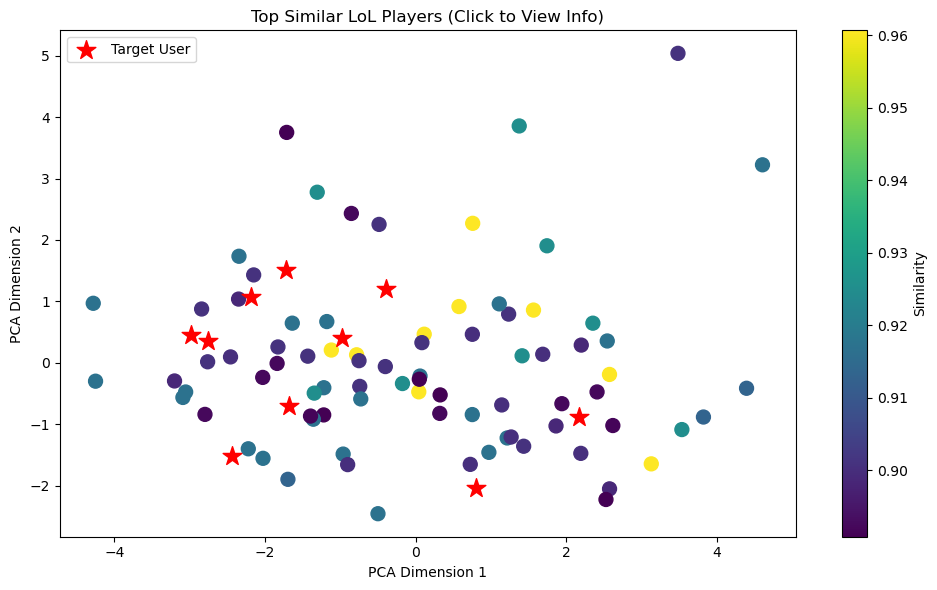

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(plot_df["x"], plot_df["y"], c=plot_df["similarity"], cmap="viridis", s=100)

# 텍스트 박스 준비
annot = ax.annotate("", xy=(0,0), xytext=(20,20), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)

# 클릭 시 작동할 함수 정의
def update_annot(ind):
    i = ind["ind"][0]
    row = plot_df.iloc[i]
    text = f"""PUUID: {row['puuid']}
                KDA: {row['KDA']:.2f}
                CS/Min: {row['cs_per_min']:.2f}
                Gold/Min: {row['gold_per_min']:.2f}
                Damage/Min: {row['damage_per_min']:.2f}
                Vision Score: {row['vision_score_est']}
                Similarity: {row['similarity']:.2f}
            """
    annot.xy = (row["x"], row["y"])
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.9)

# 마우스 클릭 이벤트 연결
def on_click(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = scatter.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("button_press_event", on_click)

# 기준 유저 좌표(★)
target_row = merged_df[merged_df["puuid"] == target_puuid].copy()
target_scaled = scaler.transform(target_row[features].fillna(0))
target_pca = pca.transform(target_scaled)
ax.scatter(target_pca[:, 0], target_pca[:, 1], c="red", marker="*", s=200, label="Target User")
ax.legend()


plt.title("Top Similar LoL Players (Click to View Info)")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.colorbar(scatter, label="Similarity")
plt.tight_layout()
plt.show()

### 상대적 거리 좌표 생성 (유사도 → 거리 변환)
기준 유저를 중심으로        
유사도가 높을수록 가까운 거리,      
       낮을수록 멀리 배치

In [29]:
import numpy as np

# 유사도 기반 거리 계산 (0~1 사이 → 가까울수록 유사함)
top_similar_players["distance"] = 1 - top_similar_players["similarity"]

# 간단한 원형 배치: 유사한 순서대로 각도를 나눠서 원 주변에 배치
angles = np.linspace(0, 2 * np.pi, len(top_similar_players), endpoint=False)
top_similar_players["x"] = np.cos(angles) * top_similar_players["distance"]
top_similar_players["y"] = np.sin(angles) * top_similar_players["distance"]

# 파생 지표 붙이기 (중복 제거 주의!)
top_features = merged_df[["game_id", "participant_id", "KDA", "cs_per_min", "gold_per_min"]].copy()
top_similar_players = pd.merge(
    top_similar_players,
    top_features,
    on=["game_id", "participant_id"],
    how="left"
)

# 기준 유저 좌표 (항상 중심)
target_user_df = pd.DataFrame({
    "puuid": [target_puuid],
    "x": [0.0],
    "y": [0.0],
    "KDA": merged_df.loc[merged_df["puuid"] == target_puuid, "KDA"].values[0],
    "cs_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "cs_per_min"].values[0],
    "gold_per_min": merged_df.loc[merged_df["puuid"] == target_puuid, "gold_per_min"].values[0],
    "label": ["Target"]
})

# 상위 유저 + 타겟 유저 병합
top_similar_players["label"] = "Top"
plot_df = pd.concat([top_similar_players, target_user_df], ignore_index=True)


In [30]:
# import plotly.express as px

# # Plotly용 데이터 준비
# fig = px.scatter(
#     plot_df,
#     x="x", y="y",
#     color="similarity",
#     hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
#     text="label",
#     color_continuous_scale="Viridis",
#     title="Similarity-based Positioning (Target User = Center)"
# )

# # 기준 유저 강조 (색 없음, hover로만 표시됨)
# fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))

# fig.show()


### Plotly로 시각화
- 기준 유저와 유사한 Top 유저들을 2D 공간에 배치하고    
   유사도, KDA, CS/분 등의 정보를 마우스만으로 직관적으로 파악
- 색상, 크기, 마커, 텍스트 등 시각 정보를 다차원적으로 표현



In [31]:
# 기준 유저 따로 빨간 점으로 표시
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px

# Plotly용 데이터 준비
fig = px.scatter(
    plot_df,
    x="x", y="y",
    color="similarity",
    # 마우스를 올리면 나오는 정보
    hover_data=["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"],
    text="label",
    color_continuous_scale="Viridis",
    title="Similarity-based Positioning (Target User = Center)"
)

# 기준 유저 강조 (색 없음, hover로만 표시됨)
fig.update_traces(marker=dict(size=14, line=dict(width=1, color='DarkSlateGrey')))


target_trace = px.scatter(
    target_user_df,
    x="x", y="y",
    hover_data=["KDA", "cs_per_min", "gold_per_min"],
    text=["You"],
)

target_trace.update_traces(marker=dict(size=16, color='red', symbol='star'))
fig.add_trace(target_trace.data[0])


### 일반 유저 + 상위 유저 지표 비교 막대그래프 같이 그리기
- 기준 유저(일반 유저)의 최근 10게임의 KDA 변화를 시각화

- 상위 1000명 유저들의 평균 KDA 선과 비교

- 사용자에게 실력의 흐름 + 상대적 수준을 한눈에 보여주는 것

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# import pandas as pd

# # 1. 기준 유저 게임 가져오기
# user_games = merged_df[(merged_df["puuid"] == target_puuid)].copy()
# user_games = user_games.sort_values("game_id", ascending=False).head(10)

# # 2. KDA 데이터 부족 시 채우기 (0으로)
# kda_values = user_games["KDA"].tolist()
# kda_values += [0] * (10 - len(kda_values))  # 10게임 채우기

# # 2-1 CS 데이터 부족 시 채우기
# cs_values = user_games["cs_per_min"].tolist()
# cs_values += [0] * (10 - len(cs_values))


# # 3. x축 레이블
# x_labels = [f"Game {i+1}" for i in range(10)]

# # 4. Top 평균 KDA
# top_avg_kda = merged_df[merged_df["is_top1000"] == True]["KDA"].mean()

# # 4-1. Top 평균 CS
# top_avg_cs = merged_df[merged_df["is_top1000"] == True]["cs_per_min"].mean()


# # # 5. 그래프 생성
# # fig = go.Figure()

# # # 유저 KDA 막대
# # fig.add_trace(go.Bar(
# #     x=x_labels,
# #     y=kda_values,
# #     name="Target User KDA",
# #     marker_color='royalblue'
# # ))

# # # Top 유저 평균 선
# # fig.add_trace(go.Scatter(
# #     x=x_labels,
# #     y=[top_avg_kda] * 10,
# #     name="Top Players Avg KDA",
# #     mode='lines',
# #     line=dict(color='red', dash='dash')
# # ))

# # fig.update_layout(
# #     title="Recent 10 Games KDA vs Top Player Avg KDA",
# #     xaxis_title="Game",
# #     yaxis_title="KDA",
# #     barmode='group',
# #     template='plotly_white'
# # )

# # fig.show()

# # 두 개의 서브플롯 생성 (1행 2열)
# fig = make_subplots(
#     rows=1, cols=2, subplot_titles=("KDA vs Top Avg", "CS per Min vs Top Avg")
# )

# # Target 유저 데이터
# fig.add_trace(
#     go.Bar(x=x_labels, y=kda_values, name="Target User KDA", marker_color="royalblue"),
#     row=1,
#     col=1,
# )
# fig.add_trace(
#     go.Scatter(
#         x=x_labels,
#         y=[top_avg_kda] * 10,
#         name="Top Players Avg KDA",
#         line=dict(color="red", dash="dash"),
#     ),
#     row=1,
#     col=1,
# )

# fig.add_trace(
#     go.Bar(x=x_labels, y=cs_values, name="Target User CS/Min", marker_color="seagreen"),
#     row=1,
#     col=2,
# )
# fig.add_trace(
#     go.Scatter(
#         x=x_labels,
#         y=[top_avg_cs] * 10,
#         name="Top Players Avg CS/Min",
#         line=dict(color="orange", dash="dash"),
#     ),
#     row=1,
#     col=2,
# )

# # 레이아웃 설정
# fig.update_layout(
#     title_text="Recent 10 Games Comparison: KDA vs CS per Min",
#     template="plotly_white",
#     showlegend=True,
# )

# # 축 레이블 개별 설정
# fig.update_xaxes(title_text="Game", row=1, col=1)
# fig.update_yaxes(title_text="KDA", row=1, col=1)

# fig.update_xaxes(title_text="Game", row=1, col=2)
# fig.update_yaxes(title_text="CS per Min", row=1, col=2)

# fig.show()

In [34]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 경기 10개, x축 라벨
x_labels = [f"Game {i+1}" for i in range(10)]

# 데이터 준비
user_games = merged_df[(merged_df["puuid"] == target_puuid)].copy()
user_games = user_games.sort_values("game_id", ascending=False).head(10)


def fill_10(values):
    return values.tolist() + [0] * (10 - len(values))


kda_values = fill_10(user_games["KDA"])
cs_values = fill_10(user_games["cs_per_min"])
gold_values = fill_10(user_games["gold_per_min"])
damage_values = fill_10(user_games["damage_per_min"])

# 상위 유저 평균값
top_avg_kda = merged_df[merged_df["is_top1000"] == True]["KDA"].mean()
top_avg_cs = merged_df[merged_df["is_top1000"] == True]["cs_per_min"].mean()
top_avg_gold = merged_df[merged_df["is_top1000"] == True]["gold_per_min"].mean()
top_avg_damage = merged_df[merged_df["is_top1000"] == True]["damage_per_min"].mean()

# subplot 구성
fig = make_subplots(
    rows=2,
    cols=2,
    subplot_titles=(
        "KDA vs Top Avg",
        "CS per Min vs Top Avg",
        "Gold per Min vs Top Avg",
        "Damage per Min vs Top Avg",
    ),
)

# (1,1) KDA
fig.add_trace(
    go.Bar(x=x_labels, y=kda_values, name="KDA", marker_color="royalblue"), row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_kda] * 10,
        name="Top Avg KDA",
        line=dict(color="red", dash="dash"),
    ),
    row=1,
    col=1,
)

# (1,2) CS/Min
fig.add_trace(
    go.Bar(x=x_labels, y=cs_values, name="CS/Min", marker_color="seagreen"),
    row=1,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_cs] * 10,
        name="Top Avg CS",
        line=dict(color="orange", dash="dash"),
    ),
    row=1,
    col=2,
)

# (2,1) Gold/Min
fig.add_trace(
    go.Bar(x=x_labels, y=gold_values, name="Gold/Min", marker_color="goldenrod"),
    row=2,
    col=1,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_gold] * 10,
        name="Top Avg Gold",
        line=dict(color="darkblue", dash="dash"),
    ),
    row=2,
    col=1,
)

# (2,2) Damage/Min
fig.add_trace(
    go.Bar(x=x_labels, y=damage_values, name="Damage/Min", marker_color="indianred"),
    row=2,
    col=2,
)
fig.add_trace(
    go.Scatter(
        x=x_labels,
        y=[top_avg_damage] * 10,
        name="Top Avg Damage",
        line=dict(color="black", dash="dash"),
    ),
    row=2,
    col=2,
)

# 전체 레이아웃 설정
fig.update_layout(
    title_text="Recent 10 Games Comparison (KDA / CS / Gold / Damage)",
    template="plotly_white",
    height=800,
    showlegend=False,
)

# 개별 축 설정
fig.update_xaxes(title_text="Game", row=1, col=1)
fig.update_yaxes(title_text="KDA", row=1, col=1)

fig.update_xaxes(title_text="Game", row=1, col=2)
fig.update_yaxes(title_text="CS/Min", row=1, col=2)

fig.update_xaxes(title_text="Game", row=2, col=1)
fig.update_yaxes(title_text="Gold/Min", row=2, col=1)

fig.update_xaxes(title_text="Game", row=2, col=2)
fig.update_yaxes(title_text="Damage/Min", row=2, col=2)

fig.show()

### 유사도 순 정렬된 테이블 만들기

In [33]:
import pandas as pd
from IPython.display import display

display(
    plot_df[plot_df["label"] == "Top"]
    .sort_values("similarity", ascending=False)[
        ["puuid", "KDA", "cs_per_min", "gold_per_min", "similarity"]
    ]
)


,puuid,KDA,cs_per_min,gold_per_min,similarity
0,N8s2Toz0lAW-qfSH3A0NufmmkZeVXQoqKYMDedmESurz6n...,3.333333,8.574889,517.611504,0.960658
1,JkAtetPeV8eLH-GNF14_7Z96cIMbONg0x-7yil5ZrhqURu...,5.166667,8.571203,519.099380,0.924943
2,_v3N7CJjg-9RvLsJjD-ciWb4ZtXdigRT2miD8SYenA7wnK...,3.666667,6.632733,471.255647,0.917098
3,0S7Qb-aNl4ZarGy2KldZFAAN4qum5qqCeGLJDv4vUn-d2V...,10.000000,6.606017,591.492586,0.912967
4,znTmuVKGw2_g_dApzVG2sId1sO0scMTJeeXryiMC-uNysp...,1.600000,8.204457,472.212077,0.900781
5,EVMY5lU8NxM93WsfJe1FH5irgp_daSX36OzDqSLmhoycEu...,3.400000,8.544045,474.748594,0.900137
6,BMLYrja7g84tXOAYN6an9UVxswRCySLhffkA_x8VKlFi-s...,3.750000,7.966532,496.677442,0.898521
7,mkuS-q15u1Xgel-8i20FgzR0qO16_5dV3IdJOiu6rGtQIm...,4.400000,8.686750,496.346472,0.892245
8,7UDpSRt0mNr-aRORdAY9-LXLEexD2goynSIcH63l2jRdYg...,7.250000,7.296867,525.751860,0.891860
9,Tjx_NecuU07AaxNwLyhT7sOX6kYjLTtSnwteY6g_jrpeya...,3.166667,9.751682,525.973625,0.890804
